# Generative Latent Prior (GLP): Learning a Diffusion Model over LLM Activations

**Paper**: [Learning a Generative Meta-Model of LLM Activations](https://arxiv.org/abs/2602.06964) (Luo et al., 2025)

## Core Idea

Instead of using PCA or Sparse Autoencoders (SAEs) to analyze LLM internals, **train a diffusion model on residual stream activations**. This "meta-model" learns the activation manifold without imposing structural assumptions (linearity, sparsity).

### Why this matters

1. **On-manifold steering**: When you steer an LLM by adding a direction vector to activations (e.g., "make output more positive"), large perturbations push activations off the natural manifold, causing gibberish. A diffusion model can project steered activations *back onto the manifold* (like SDEdit for images).

2. **Interpretable meta-neurons**: The diffusion model's internal neurons learn to isolate semantic concepts into individual units—better than SAE features or raw LLM neurons.

3. **Predictable scaling**: Diffusion loss follows a power law with compute, and downstream utility (steering quality, probe accuracy) tracks this loss.

### Method: Flow Matching

GLP uses **flow matching**, a variant of diffusion:

- **Forward process**: Linearly interpolate between data and noise: $z_t = (1-t)z_0 + t\epsilon$, where $t \in [0,1]$
- **Velocity target**: The network learns to predict $u = \epsilon - z_0$ (the direction from data to noise)
- **Reverse process**: Start from noise $z_1 \sim \mathcal{N}(0,I)$ and iteratively denoise using predicted velocity
- **Architecture**: Stack of SwiGLU MLP blocks (no attention—each token is modeled independently)

### On-Manifold Steering Algorithm

1. Apply steering: $a_{\text{edit}} = a + \alpha \cdot w$ (where $w$ is a steering direction)
2. Add noise to $t_{\text{start}}$: $a_{\text{noisy}} = (1-t_{\text{start}}) \cdot a_{\text{edit}} + t_{\text{start}} \cdot \epsilon$
3. Run diffusion denoising from $t_{\text{start}}$ back to $t=0$ (NOT from $t=1$, so we preserve structure)
4. This projects the steered activation back onto the learned manifold

### Exercise Overview

You will:
1. **Extract activations** from a small LLM using `nnsight`
2. **Implement flow matching** (forward process + velocity prediction loss)
3. **Train a tiny GLP** on those activations
4. **Implement on-manifold steering** (the SDEdit-style projection)
5. **Probe meta-neurons** to see if they capture interpretable concepts

Estimated time: ~45 minutes

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jaxtyping import Float
from torch import Tensor
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Part 1: Extract Activations from a Small LLM

We use `nnsight` to collect residual stream activations from a middle layer of a small language model. The paper uses ~1B activations; we'll use a much smaller set for tractability.

In [2]:
from nnsight import LanguageModel
from datasets import load_dataset

# Load a small model
model_name = "HuggingFaceTB/SmolLM2-135M"
model = LanguageModel(model_name, device_map=device, dispatch=True)
tokenizer = model.tokenizer
tokenizer.pad_token = tokenizer.eos_token

n_layers = model.config.num_hidden_layers
d_model = model.config.hidden_size
target_layer = n_layers // 2  # Middle layer, as in the paper

print(f"Model: {model_name}")
print(f"Layers: {n_layers}, d_model: {d_model}")
print(f"Extracting from layer {target_layer}")

Loading weights:   0%|          | 0/272 [00:00<?, ?it/s]

Model: HuggingFaceTB/SmolLM2-135M
Layers: 30, d_model: 576
Extracting from layer 15


In [ ]:
# Load a small text corpus
ds = load_dataset(
    "HuggingFaceTB/smollm-corpus", "cosmopedia-v2", split="train", streaming=True
)

# Collect activations
all_activations = []
all_tokens = []
num_texts = 200
max_len = 128

texts = []
for i, example in enumerate(ds):
    if i >= num_texts:
        break
    texts.append(example["text"][:512])  # truncate long texts

print(f"Collected {len(texts)} texts, tokenizing...")

# grab residual stream activations from all tokens in the middle layer for all texts, truncating texts longer than 512 characters to 512
batch_size = 20
for i in tqdm(range(0, len(texts), batch_size), desc="Extracting activations"):
    batch_texts = texts[i : i + batch_size]
    tokens = tokenizer(
        batch_texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_len,
    )
    input_ids = tokens["input_ids"].to(device)
    attention_mask = tokens["attention_mask"].to(device)

    # grab residual stream output at middle layer
    with torch.no_grad():
        with model.trace(input_ids, attention_mask=attention_mask):
            # Grab residual stream output at the target layer
            hidden = model.model.layers[target_layer].output.save()

    acts = hidden.float().cpu()  # (batch, seq_len, d_model)
    mask = attention_mask.cpu().bool()

    # Flatten: keep only non-padding, non-BOS tokens (as in the paper)
    for b in range(acts.shape[0]):
        valid = mask[b].clone()
        valid[0] = False  # skip BOS
        if valid.sum() > 0:
            all_activations.append(acts[b, valid])
            all_tokens.append(input_ids[b, valid].cpu())

# concatenate activations together in the first dimensino
activations = torch.cat(all_activations, dim=0)  # (N, d_model)
token_ids = torch.cat(all_tokens, dim=0)  # (N,)

print(
    f"\nCollected {activations.shape[0]:,} activation vectors of dim {activations.shape[1]}"
)
print(f"Activation stats: mean={activations.mean():.3f}, std={activations.std():.3f}")

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Collected 200 texts, tokenizing...


Extracting activations:   0%|          | 0/10 [00:00<?, ?it/s]


Collected 20,410 activation vectors of dim 576
Activation stats: mean=0.203, std=79.955


In [4]:
mask.shape

torch.Size([20, 125])

In [5]:
valid.sum().item() > 0

True

In [ ]:
# Standardize activations (the paper does this for the steering algorithm)
act_mean = activations.mean(dim=0)
act_std = activations.std(dim=0)

activations_normed = (activations - act_mean) / (act_std + 1e-8)

print(
    f"Normalized stats: mean={activations_normed.mean():.4f}, std={activations_normed.std():.4f}"
)

# Train/val split
n = activations_normed.shape[0]
n_val = min(2000, n // 10)

# permute activations... do they do this in the paper?
perm = torch.randperm(n)
val_acts = activations_normed[perm[:n_val]]
train_acts = activations_normed[perm[n_val:]]
train_token_ids = token_ids[perm[n_val:]]
val_token_ids = token_ids[perm[:n_val]]

print(f"Train: {train_acts.shape[0]:,}, Val: {val_acts.shape[0]:,}")

Normalized stats: mean=0.0000, std=1.0000
Train: 18,410, Val: 2,000


## Part 2: Implement Flow Matching

The core of GLP is a **flow matching** diffusion model. Unlike DDPM which predicts noise, flow matching predicts the *velocity* of a linear interpolation between data and noise.

**Forward process** (adding noise):
$$z_t = (1 - t) \cdot z_0 + t \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I), \quad t \in [0, 1]$$

**Velocity target** (what the network learns to predict):
$$u = \epsilon - z_0$$

**Training loss** (MSE on predicted velocity):
$$\mathcal{L} = \mathbb{E}_{z_0, \epsilon, t} \left[ \| u_\theta(z_t, t) - (\epsilon - z_0) \|^2 \right]$$

In [16]:
def flow_matching_forward(
    z0: Float[Tensor, "batch dim"],
    t: Float[Tensor, "batch 1"],
) -> tuple[
    Float[Tensor, "batch dim"],  # z_t (noisy sample)
    Float[Tensor, "batch dim"],  # velocity target
]:
    """
    Flow matching forward process.

    Given clean data z0 and timesteps t, produce:
      - z_t: the noisy interpolation
      - velocity: the target for the denoiser to predict

    Args:
        z0: Clean activation vectors [batch, dim]
        t: Timesteps in [0, 1], shape [batch, 1]

    Returns:
        (z_t, velocity_target)
    """
    epsilon = torch.randn_like(z0)
    z_t = (1 - t) * z0 + t * epsilon
    velocity_target = epsilon - z0
    return z_t, velocity_target

In [17]:
# Test flow matching forward
torch.manual_seed(42)
test_z0 = torch.randn(4, 8)
test_t = torch.zeros(4, 1)  # t=0 should return z0

zt, vel = flow_matching_forward(test_z0, test_t)

# At t=0, z_t should equal z0 (no noise added)
# Note: velocity target doesn't depend on t, so we just check z_t
assert zt.shape == test_z0.shape, f"Wrong shape: {zt.shape}"
assert vel.shape == test_z0.shape, f"Wrong velocity shape: {vel.shape}"
assert torch.allclose(zt, test_z0, atol=1e-6), "At t=0, z_t should equal z0"

# At t=1, z_t should be pure noise (epsilon)
test_t_one = torch.ones(4, 1)
zt_one, vel_one = flow_matching_forward(test_z0, test_t_one)
# z_t = 0 * z0 + 1 * epsilon = epsilon, and velocity = epsilon - z0
# So z_t should equal vel + z0
assert torch.allclose(zt_one, vel_one + test_z0, atol=1e-6), (
    "At t=1, z_t should equal epsilon = velocity + z0"
)

print("✓ Flow matching forward process tests passed")

✓ Flow matching forward process tests passed


## Part 3: Build the GLP Denoiser Network

The paper uses a stack of **SwiGLU MLP blocks** with **timestep conditioning** via multiplicative modulation.

Architecture:
- Width = 2× activation dimension
- MLP expansion = 2× width (so 4× activation dim)
- Timestep conditioning: modulate the SwiGLU gate pre-activation
- Residual connections
- No attention (each token is independent)

For this exercise, we'll build a smaller version.

In [21]:
class TimestepEmbedding(nn.Module):
    """Embed scalar timestep into a vector using sinusoidal encoding."""

    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * 2),
            nn.SiLU(),
            nn.Linear(dim * 2, dim),
        )

    def forward(self, t: Float[Tensor, "batch"]) -> Float[Tensor, "batch dim"]:
        # Sinusoidal encoding (same as positional encoding)
        half = self.dim // 2
        freqs = torch.exp(-np.log(10000.0) * torch.arange(half, device=t.device) / half)
        args = t[:, None] * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.mlp(emb)


class SwiGLUBlock(nn.Module):
    """
    SwiGLU MLP block with timestep conditioning.

    The paper modulates the gate pre-activation multiplicatively with the timestep embedding.

    SwiGLU: output = (W_up @ x) * silu(W_gate @ x)
    With timestep: output = (W_up @ x) * silu(W_gate @ x * (1 + t_scale))
    """

    def __init__(self, dim: int, expansion: int = 4):
        super().__init__()
        hidden = dim * expansion

        self.W_gate = nn.Linear(dim, hidden)
        self.W_up = nn.Linear(dim, hidden)
        self.W_down = nn.Linear(hidden, dim)
        self.t_proj = nn.Linear(dim, hidden)
        self.layer_norm = nn.LayerNorm(dim)

    def forward(
        self,
        x: Float[Tensor, "batch dim"],
        t_emb: Float[Tensor, "batch dim"],
    ) -> Float[Tensor, "batch dim"]:
        """
        Forward pass with residual connection.

        1. Layer norm on x
        2. Compute gate = W_gate(x_normed)
        3. Compute timestep scale = t_proj(t_emb)
        4. Modulate: gate = gate * (1 + scale)  <-- this is the key innovation
        5. Compute up = W_up(x_normed)
        6. SwiGLU: hidden = up * silu(gate)
        7. Project down: out = W_down(hidden)
        8. Residual: return x + out
        """
        # TODO: Implement the forward pass
        residual = x
        x = self.layer_norm(x)

        gate = self.W_gate(x)
        scale = self.t_proj(t_emb)

        # key innovation
        gate = gate * (1 + scale)

        up = self.W_up(x)
        hidden = up * F.silu(gate)
        out = self.W_down(hidden)

        return residual + out

In [22]:
class GLP(nn.Module):
    """
    Generative Latent Prior: a flow-matching diffusion model for LLM activations.

    Architecture: input_proj -> N x SwiGLU blocks -> output_proj
    """

    def __init__(
        self,
        act_dim: int,
        hidden_dim: int,
        n_blocks: int = 4,
        expansion: int = 4,
    ):
        super().__init__()
        self.act_dim = act_dim
        self.time_embed = TimestepEmbedding(hidden_dim)
        self.input_proj = nn.Linear(act_dim, hidden_dim)
        self.blocks = nn.ModuleList([
            SwiGLUBlock(hidden_dim, expansion) for _ in range(n_blocks)
        ])
        self.output_norm = nn.LayerNorm(hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, act_dim)

    def forward(
        self,
        z_t: Float[Tensor, "batch act_dim"],
        t: Float[Tensor, "batch"],
    ) -> Float[Tensor, "batch act_dim"]:
        """
        Predict velocity given noisy activations and timestep.

        1. Embed timestep
        2. Project input to hidden dim
        3. Pass through SwiGLU blocks (each gets timestep embedding)
        4. Project back to activation dim
        """
        # TODO: Implement forward pass
        t_emb = self.time_embed(t)
        h = self.input_proj(z_t)
        for block in self.blocks:
            h = block(h, t_emb)
        h = self.output_norm(h)
        return self.output_proj(h)

In [23]:
# Quick shape test
torch.manual_seed(0)
test_glp = GLP(act_dim=d_model, hidden_dim=d_model * 2, n_blocks=4).to(device)
n_params = sum(p.numel() for p in test_glp.parameters())
print(f"GLP parameters: {n_params:,}")

test_input = torch.randn(8, d_model, device=device)
test_t = torch.rand(8, device=device)
test_out = test_glp(test_input, test_t)

assert test_out.shape == (8, d_model), f"Wrong output shape: {test_out.shape}"
print(f"✓ GLP output shape correct: {test_out.shape}")
del test_glp

GLP parameters: 91,646,784
✓ GLP output shape correct: torch.Size([8, 576])


## Part 4: Train the GLP

Training loop:
1. Sample a batch of activations $z_0$
2. Sample random timesteps $t \sim \text{Uniform}(0, 1)$
3. Compute noisy samples $z_t$ and velocity targets via `flow_matching_forward`
4. Predict velocity with the GLP network
5. Minimize MSE between predicted and target velocity

In [24]:
# Hyperparameters (small for tractability)
hidden_dim = d_model * 2
n_blocks = 4
batch_size = 512
lr = 5e-4
n_epochs = 30

glp = GLP(act_dim=d_model, hidden_dim=hidden_dim, n_blocks=n_blocks).to(device)
optimizer = torch.optim.AdamW(glp.parameters(), lr=lr, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

train_dataset = TensorDataset(train_acts)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

n_params = sum(p.numel() for p in glp.parameters())
print(f"Training GLP: {n_params:,} params, {len(train_loader)} batches/epoch")
print(f"Activation dim: {d_model}, Hidden dim: {hidden_dim}, Blocks: {n_blocks}")

Training GLP: 91,646,784 params, 35 batches/epoch
Activation dim: 576, Hidden dim: 1152, Blocks: 4


In [26]:
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    glp.train()
    epoch_loss = 0.0
    n_batches = 0

    for (z0_batch,) in train_loader:
        z0_batch = z0_batch.to(device)
        bs = z0_batch.shape[0]

        t = torch.rand(bs, 1, device=device)
        z_t, velocity_target = flow_matching_forward(z0_batch, t)
        velocity_pred = glp(z_t, t.squeeze(-1))
        loss = F.mse_loss(velocity_pred, velocity_target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    scheduler.step()
    avg_train = epoch_loss / n_batches
    train_losses.append(avg_train)

    # Validation
    glp.eval()
    with torch.no_grad():
        val_z0 = val_acts.to(device)
        val_t = torch.rand(val_z0.shape[0], 1, device=device)
        val_zt, val_vel = flow_matching_forward(val_z0, val_t)
        val_pred = glp(val_zt, val_t.squeeze(-1))
        val_loss = F.mse_loss(val_pred, val_vel).item()
    val_losses.append(val_loss)

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(
            f"Epoch {epoch + 1:3d}/{n_epochs} | Train loss: {avg_train:.4f} | Val loss: {val_loss:.4f}"
        )

Epoch   1/30 | Train loss: 1.8344 | Val loss: 1.6195
Epoch   5/30 | Train loss: 1.3771 | Val loss: 1.3998
Epoch  10/30 | Train loss: 1.1816 | Val loss: 1.2351
Epoch  15/30 | Train loss: 1.0676 | Val loss: 1.1228
Epoch  20/30 | Train loss: 0.9989 | Val loss: 1.0908
Epoch  25/30 | Train loss: 0.9568 | Val loss: 1.0661
Epoch  30/30 | Train loss: 0.9416 | Val loss: 1.0542


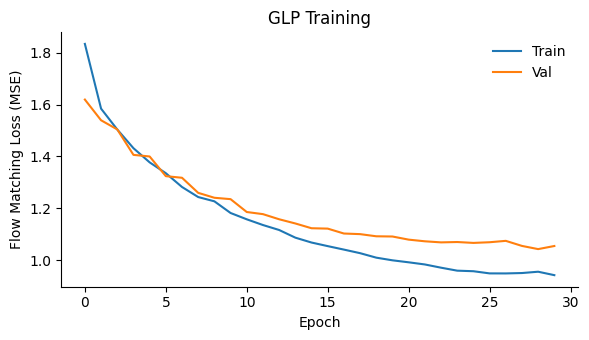

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(train_losses, label="Train", linewidth=1.5)
ax.plot(val_losses, label="Val", linewidth=1.5)
ax.set_xlabel("Epoch")
ax.set_ylabel("Flow Matching Loss (MSE)")
ax.set_title("GLP Training")
ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
sns.despine()
plt.tight_layout()
plt.show()

## Part 5: Generate Activations & Evaluate Quality

**Reverse process** (sampling from noise):

Start at $z_1 \sim \mathcal{N}(0, I)$ and iteratively step:
$$z_{t'} = z_t + \hat{u}_\theta(z_t, t) \cdot (t' - t)$$

where we step from $t=1$ down to $t=0$ in small increments.

We evaluate using the **Representation Fréchet Distance (FD)**: the Fréchet distance between the distributions of real and generated activations (analogous to FID for images).

In [28]:
@torch.no_grad()
def sample_glp(
    model: GLP,
    n_samples: int,
    act_dim: int,
    num_steps: int = 50,
    device: torch.device = torch.device("cpu"),
) -> Float[Tensor, "n_samples act_dim"]:
    """
    Generate activation samples via the reverse diffusion process.

    Start from z_1 ~ N(0, I) and iteratively denoise to z_0.

    Euler method: z_{t'} = z_t + velocity_pred * (t' - t)
    where we go from t=1.0 down to t=0.0
    """
    model.eval()

    z = torch.randn(n_samples, act_dim, device=device)
    schedule = torch.linspace(1.0, 0.0, num_steps + 1, device=device)

    for i in range(num_steps):
        t_curr = schedule[i]
        t_next = schedule[i + 1]
        dt = t_next - t_curr

        t_batch = torch.full((n_samples,), t_curr, device=device)
        velocity = model(z, t_batch)
        z = z + velocity * dt

    return z

In [29]:
def frechet_distance(
    real: Float[Tensor, "n dim"],
    fake: Float[Tensor, "m dim"],
) -> float:
    """
    Compute Fréchet Distance between two sets of vectors.

    FD = ||mu_r - mu_f||^2 + Tr(C_r + C_f - 2*(C_r @ C_f)^{1/2})

    This is the activation-space analog of FID.
    """
    mu_r = real.mean(dim=0)
    mu_f = fake.mean(dim=0)

    # Covariance matrices
    real_centered = real - mu_r
    fake_centered = fake - mu_f
    cov_r = (real_centered.T @ real_centered) / (real.shape[0] - 1)
    cov_f = (fake_centered.T @ fake_centered) / (fake.shape[0] - 1)

    # Mean difference term
    diff = mu_r - mu_f
    mean_term = (diff @ diff).item()

    # Matrix square root via eigendecomposition
    product = cov_r @ cov_f
    eigvals = torch.linalg.eigvalsh(product)
    eigvals = torch.clamp(eigvals, min=0)  # numerical stability
    sqrt_product_trace = eigvals.sqrt().sum().item()

    fd = (
        mean_term + cov_r.trace().item() + cov_f.trace().item() - 2 * sqrt_product_trace
    )
    return fd

In [30]:
# Generate samples and compute FD
n_gen = min(2000, val_acts.shape[0])
generated = sample_glp(glp, n_gen, d_model, num_steps=50, device=device).cpu()

fd_generated = frechet_distance(val_acts[:n_gen], generated)

# Baseline: FD between two halves of real data (lower bound)
half = n_gen // 2
fd_baseline = frechet_distance(val_acts[:half], val_acts[half : 2 * half])

# FD of pure noise (upper bound)
noise = torch.randn_like(generated)
fd_noise = frechet_distance(val_acts[:n_gen], noise)

print(f"Fréchet Distance:")
print(f"  Real vs Real (lower bound): {fd_baseline:.2f}")
print(f"  Real vs GLP generated:      {fd_generated:.2f}")
print(f"  Real vs Random noise:        {fd_noise:.2f}")

Fréchet Distance:
  Real vs Real (lower bound): -286.32
  Real vs GLP generated:      -352.31
  Real vs Random noise:        277.22


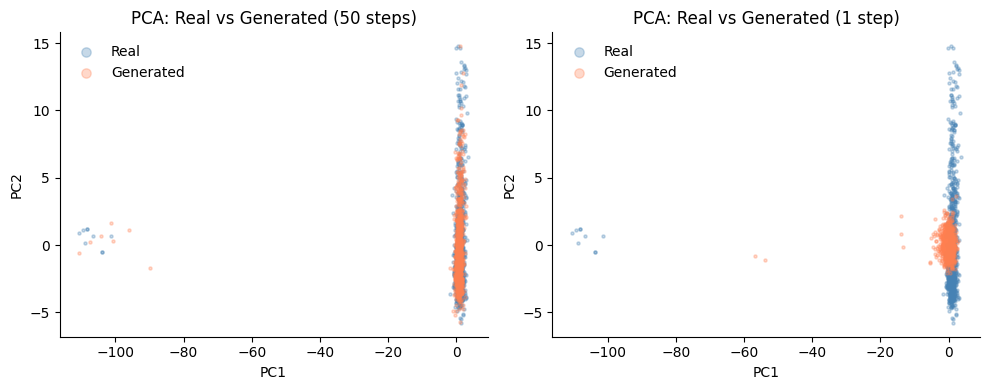


With more steps, generated samples should better cover the real distribution modes.


In [31]:
# PCA visualization (cf. Figure 3 in the paper)
from sklearn.decomposition import PCA

n_viz = 1000
real_sample = val_acts[:n_viz].numpy()
gen_sample = generated[:n_viz].numpy()

pca = PCA(n_components=2).fit(real_sample)
real_2d = pca.transform(real_sample)
gen_2d = pca.transform(gen_sample)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(
    real_2d[:, 0], real_2d[:, 1], alpha=0.3, s=5, c="steelblue", label="Real"
)
axes[0].scatter(
    gen_2d[:, 0], gen_2d[:, 1], alpha=0.3, s=5, c="coral", label="Generated"
)
axes[0].legend(frameon=False, markerscale=3)
axes[0].set_title("PCA: Real vs Generated (50 steps)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Also show 1-step generation for comparison (should be worse)
gen_1step = sample_glp(glp, n_viz, d_model, num_steps=1, device=device).cpu().numpy()
gen_1_2d = pca.transform(gen_1step)

axes[1].scatter(
    real_2d[:, 0], real_2d[:, 1], alpha=0.3, s=5, c="steelblue", label="Real"
)
axes[1].scatter(
    gen_1_2d[:, 0], gen_1_2d[:, 1], alpha=0.3, s=5, c="coral", label="Generated"
)
axes[1].legend(frameon=False, markerscale=3)
axes[1].set_title("PCA: Real vs Generated (1 step)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()
print(
    "\nWith more steps, generated samples should better cover the real distribution modes."
)

## Part 6: On-Manifold Steering

This is the paper's key practical contribution. When you steer an LLM by adding a direction to activations:
- Small perturbations → ok
- Large perturbations → off-manifold → gibberish

**GLP fix**: Initialize diffusion at an intermediate timestep $t_{\text{start}}$ (not $t=1$) from the steered activation, then denoise. This is exactly **SDEdit** applied to activation space.

The algorithm:
1. Steer: $a_{\text{edit}} = a + \alpha \cdot w$
2. Standardize to zero mean / unit variance
3. Add noise: $a_{\text{noisy}} = (1 - t_{\text{start}}) \cdot a_{\text{edit}} + t_{\text{start}} \cdot \epsilon$
4. Denoise from $t_{\text{start}}$ → $0$ (preserves more of the edit than starting from $t=1$)
5. Unstandardize back to original scale

In [32]:
@torch.no_grad()
def on_manifold_steer(
    model: GLP,
    activations: Float[Tensor, "batch dim"],
    steering_direction: Float[Tensor, "dim"],
    alpha: float,
    t_start: float = 0.5,
    num_steps: int = 20,
    act_mean: Float[Tensor, "dim"] | None = None,
    act_std: Float[Tensor, "dim"] | None = None,
) -> Float[Tensor, "batch dim"]:
    """
    Steer activations and project back onto manifold using GLP.

    This is the SDEdit-style algorithm from Section 4 of the paper.

    Args:
        model: Trained GLP model
        activations: Original (unnormalized) activations
        steering_direction: Unit direction vector to steer along
        alpha: Steering strength (paper uses r * ||a||_2)
        t_start: Noise level to start denoising from (0.5 = moderate correction)
        num_steps: Number of denoising steps
        act_mean, act_std: Statistics for standardization

    Returns:
        Steered activations projected back onto the manifold
    """
    model.eval()
    dev = activations.device
    bs = activations.shape[0]

    acts_edit = activations + alpha * steering_direction

    if act_mean is not None and act_std is not None:
        acts_normed = (acts_edit - act_mean) / (act_std + 1e-8)
    else:
        acts_normed = acts_edit

    noise = torch.randn_like(acts_normed)
    z = (1 - t_start) * acts_normed + t_start * noise

    schedule = torch.linspace(t_start, 0.0, num_steps + 1, device=dev)
    for i in range(num_steps):
        t_curr = schedule[i]
        t_next = schedule[i + 1]
        dt = t_next - t_curr

        t_batch = torch.full((bs,), t_curr, device=dev)
        velocity = model(z, t_batch)
        z = z + velocity * dt

    if act_mean is not None and act_std is not None:
        result = z * (act_std + 1e-8) + act_mean
    else:
        result = z

    return result

In [33]:
# Demo: steer activations and compare naive vs on-manifold
# We'll compute a simple steering direction using the DiffMean method
# (difference in mean activations between two groups of tokens)

# Split tokens into two groups by a simple heuristic:
# tokens that tend to appear in questions vs. statements
# We'll use a simpler proxy: high vs low activation norm

norms = train_acts.norm(dim=-1)
median_norm = norms.median()
high_norm = train_acts[norms > median_norm]
low_norm = train_acts[norms <= median_norm]

# DiffMean steering direction
steer_dir = high_norm.mean(dim=0) - low_norm.mean(dim=0)
steer_dir = steer_dir / steer_dir.norm()  # unit vector

print(f"Steering direction norm: {steer_dir.norm():.4f}")
print(f"Mean activation norm: {train_acts.norm(dim=-1).mean():.4f}")

# Take a batch of test activations
test_batch = val_acts[:200].to(device)

# Sweep over steering strengths
alphas = [0.0, 1.0, 3.0, 5.0, 10.0, 20.0]
fd_naive = []
fd_glp = []

reference = val_acts[200:400]  # separate reference set for FD

for alpha in alphas:
    # Naive steering (just add the direction)
    naive_steered = test_batch + alpha * steer_dir.to(device)
    naive_normed = (naive_steered.cpu() - act_mean) / (
        act_std + 1e-8
    )  # normalize for FD comparison
    fd_n = frechet_distance(val_acts[200:400], naive_normed)
    fd_naive.append(fd_n)

    # On-manifold steering
    if alpha > 0:
        glp_steered = on_manifold_steer(
            glp,
            test_batch,
            steer_dir.to(device),
            alpha,
            t_start=0.5,
            num_steps=20,
            act_mean=act_mean.to(device),
            act_std=act_std.to(device),
        )
        glp_normed = (glp_steered.cpu() - act_mean) / (act_std + 1e-8)
        fd_g = frechet_distance(val_acts[200:400], glp_normed)
    else:
        fd_g = fd_n
    fd_glp.append(fd_g)

    print(f"α={alpha:5.1f} | FD naive: {fd_n:8.2f} | FD GLP: {fd_g:8.2f}")

Steering direction norm: 1.0000
Mean activation norm: 22.2198
α=  0.0 | FD naive:   -48.31 | FD GLP:   -48.31
α=  1.0 | FD naive:   -48.92 | FD GLP:  -432.55
α=  3.0 | FD naive:   -49.61 | FD GLP:  -442.72
α=  5.0 | FD naive:   -49.57 | FD GLP:  -459.45
α= 10.0 | FD naive:   -46.27 | FD GLP:  -439.94
α= 20.0 | FD naive:   -25.98 | FD GLP:  -631.04


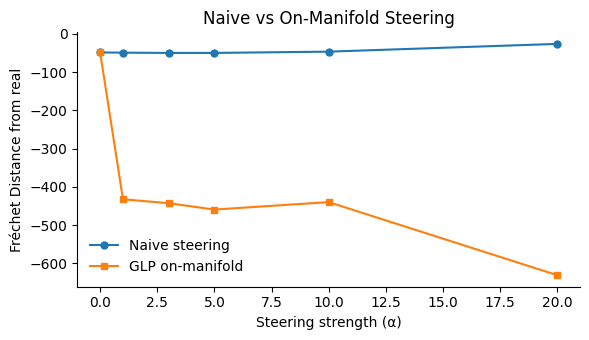


Key insight: At large α, naive steering diverges from the real distribution.
GLP on-manifold steering keeps activations closer to the learned manifold.


In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(alphas, fd_naive, "o-", label="Naive steering", linewidth=1.5, markersize=5)
ax.plot(alphas, fd_glp, "s-", label="GLP on-manifold", linewidth=1.5, markersize=5)
ax.set_xlabel("Steering strength (α)")
ax.set_ylabel("Fréchet Distance from real")
ax.set_title("Naive vs On-Manifold Steering")
ax.legend(frameon=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

print("\nKey insight: At large α, naive steering diverges from the real distribution.")
print("GLP on-manifold steering keeps activations closer to the learned manifold.")

## Part 7: Probing Meta-Neurons

The paper's other key finding: the GLP's *internal neurons* ("meta-neurons") learn to isolate semantic concepts better than SAE features or raw LLM neurons.

To test this, we:
1. Run real activations through the GLP's first few layers to get meta-neuron activations
2. Define binary concept labels for our tokens (e.g., "is this a number?", "is this punctuation?")
3. Measure how well individual meta-neurons predict each concept (1-D probe AUC)

In [ ]:
@torch.no_grad()
def extract_meta_neurons(
    model: GLP,
    activations: Float[Tensor, "n dim"],
    t: float = 0.0,
    layer_idx: int = 1,
) -> Float[Tensor, "n hidden_dim"]:
    """
    Extract intermediate representations (meta-neurons) from the GLP.

    Pass activations through the GLP at timestep t, and return
    the hidden representation after `layer_idx` SwiGLU blocks.

    Args:
        model: Trained GLP
        activations: Normalized activation vectors
        t: Timestep to condition on (0.0 = clean data)
        layer_idx: Which SwiGLU block's output to extract (0-indexed)

    Returns:
        Hidden representations at the specified layer
    """
    model.eval()

    # TODO: Embed timestep (create a batch of identical timesteps)
    # TODO: Project activations to hidden dim
    # TODO: Pass through SwiGLU blocks up to layer_idx (inclusive)
    # TODO: Return the hidden state

    pass

In [ ]:
# Define binary token-level concepts to probe
def make_concept_labels(token_ids: Tensor, tokenizer) -> dict[str, Tensor]:
    """Create binary labels for various token-level concepts."""
    decoded = [tokenizer.decode([tid]) for tid in token_ids.tolist()]

    concepts = {}

    # Punctuation
    punct_chars = set(".,;:!?-()[]{}\"'/")
    concepts["punctuation"] = torch.tensor([
        1.0
        if any(c in punct_chars for c in tok.strip()) and len(tok.strip()) <= 2
        else 0.0
        for tok in decoded
    ])

    # Starts with capital letter
    concepts["capitalized"] = torch.tensor([
        1.0 if tok.strip() and tok.strip()[0].isupper() else 0.0 for tok in decoded
    ])

    # Contains a digit
    concepts["has_digit"] = torch.tensor([
        1.0 if any(c.isdigit() for c in tok) else 0.0 for tok in decoded
    ])

    # Starts with space (word boundary)
    concepts["word_start"] = torch.tensor([
        1.0 if tok.startswith(" ") or tok.startswith("Ġ") else 0.0 for tok in decoded
    ])

    # Short tokens (1-2 chars after stripping)
    concepts["short_token"] = torch.tensor([
        1.0 if len(tok.strip()) <= 2 else 0.0 for tok in decoded
    ])

    for name, labels in concepts.items():
        pos = labels.sum().int().item()
        print(
            f"  {name}: {pos}/{len(labels)} positive ({100 * pos / len(labels):.1f}%)"
        )

    return concepts


print("Concept label distributions:")
concept_labels = make_concept_labels(train_token_ids, tokenizer)

In [ ]:
from sklearn.metrics import roc_auc_score


def best_1d_probe_auc(
    features: Float[Tensor, "n dim"],
    labels: Float[Tensor, "n"],
) -> tuple[float, int]:
    """
    Find the single feature (neuron) that best predicts the binary label.
    Returns (best_auc, best_feature_idx).

    This is the 1-D probe from Section 5.1 of the paper.
    """
    # Skip if label is trivial
    if labels.sum() < 5 or (1 - labels).sum() < 5:
        return 0.5, -1

    features_np = features.cpu().numpy()
    labels_np = labels.cpu().numpy()

    best_auc = 0.5
    best_idx = -1

    for i in range(features_np.shape[1]):
        auc = roc_auc_score(labels_np, features_np[:, i])
        # AUC can be < 0.5 if the neuron is anti-correlated; take max(auc, 1-auc)
        auc = max(auc, 1 - auc)
        if auc > best_auc:
            best_auc = auc
            best_idx = i

    return best_auc, best_idx

In [ ]:
# Extract meta-neuron features
meta_features = extract_meta_neurons(
    glp, train_acts.to(device), t=0.0, layer_idx=1
).cpu()
print(f"Meta-neuron features shape: {meta_features.shape}")

# Compare: raw LLM activations vs GLP meta-neurons
print(f"\n{'Concept':<15} {'Raw LLM AUC':>12} {'Meta-neuron AUC':>16}")
print("-" * 47)

results = {}
for concept_name, labels in concept_labels.items():
    # Raw LLM activations (normalized)
    raw_auc, raw_idx = best_1d_probe_auc(train_acts, labels)

    # GLP meta-neurons
    meta_auc, meta_idx = best_1d_probe_auc(meta_features, labels)

    results[concept_name] = {"raw": raw_auc, "meta": meta_auc}
    print(f"{concept_name:<15} {raw_auc:>12.3f} {meta_auc:>16.3f}")

raw_mean = np.mean([v["raw"] for v in results.values()])
meta_mean = np.mean([v["meta"] for v in results.values()])
print("-" * 47)
print(f"{'Mean':<15} {raw_mean:>12.3f} {meta_mean:>16.3f}")
print(
    f"\nThe paper finds meta-neurons consistently outperform raw neurons as 1-D probes."
)

In [ ]:
# Visualize a top meta-neuron: show highest-activating tokens
best_concept = max(results, key=lambda k: results[k]["meta"])
_, best_meta_idx = best_1d_probe_auc(meta_features, concept_labels[best_concept])

neuron_vals = meta_features[:, best_meta_idx]
top_k = 20
top_indices = neuron_vals.topk(top_k).indices
bottom_indices = neuron_vals.topk(top_k, largest=False).indices

print(f"Meta-neuron #{best_meta_idx} (best for '{best_concept}')")
print(f"\nTop-{top_k} activating tokens:")
for idx in top_indices:
    tok = tokenizer.decode([train_token_ids[idx].item()])
    print(f"  {neuron_vals[idx]:.3f}  '{tok}'")

print(f"\nBottom-{top_k} activating tokens:")
for idx in bottom_indices:
    tok = tokenizer.decode([train_token_ids[idx].item()])
    print(f"  {neuron_vals[idx]:.3f}  '{tok}'")

## Summary

You've implemented the core components of the GLP paper:

1. **Flow matching** — the forward process ($z_t = (1-t)z_0 + t\epsilon$) and velocity prediction loss
2. **SwiGLU denoiser with timestep conditioning** — the meta-model architecture
3. **Reverse sampling** — Euler integration from noise to clean activations
4. **On-manifold steering** — SDEdit-style projection that preserves fluency at large steering strengths
5. **Meta-neuron probing** — showing the GLP's internal features isolate concepts

### Key takeaways from the paper:

- **No structural assumptions**: Unlike SAEs (sparsity) or PCA (linearity), diffusion models learn the activation manifold flexibly
- **Scaling laws transfer**: Diffusion loss → downstream utility (steering quality, probe accuracy) follows a predictable power law
- **Practical**: On-manifold steering expands the Pareto frontier of concept-strength vs fluency
- **Interpretable**: Meta-neurons outperform SAE features and raw neurons on 1-D probing tasks

### Things we didn't cover (that the paper does):
- Training on 1B+ activations with the full scaling study
- Sentiment steering with LLM-as-judge evaluation
- Persona elicitation (evil/curious/helpful)
- Transfer from base model training to instruct model application
- Delta LM loss evaluation (replacing activations and measuring perplexity increase)